# 2. Scattering network design

Now that we downloaded some seismic data, we can proceed to design a seismic scattering network for the task at hand. In this Jupyter notebook, we will see the role of the scattering network parameters and how to choose them, supported with illustrations.

In [43]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

In [44]:
%config InlineBackend.figure_format = "svg"

## Design parameters

Before creating our scattering network, we need to define several key parameters. Think of these as the settings that determine how the network will analyze your seismic data.

The scattering network uses wavelets to analyze your data at different frequencies and time scales. 

At first, we need to provide the data characteristics: the **sampling rate** $f_S$ is fixed and can be automatically read from the data (here defined from the previous notebook), while the **segment duration** is chosen based on the expected duration of the seismic events of interest. Here we define it as 40 seconds, which is long enough to capture tremor patterns.

Then for each layer, we define three parameters: the number of octaves $J$, the resolution $Q$, and the quality factor $Q_f$ (keeping the notations consistent with the Andén and Mallat, [2014](https://www.di.ens.fr/~mallat/papiers/AudioScatSpectrum.pdf)):

- The first layer of the network examines the input signal in terms of frequency contents. For this first layer, the number of octaves $J$ defines the frequency range from the Nyquist frequency $f_N= f_S/2$ down to $f_\text{min} = f_N/2^J$. In other terms, with a sampling rate of 50 Hz and $J=6$ octaves, we analyze frequencies from 25 Hz down to approximately 0.39 Hz (as illustrated with the plot at the bottom of the notebook). We use a dense frequency represenatation with a high resolution $Q$ (number of wavelets per octave) to capture detailed frequency content (here 4). Finally, the quality factor $Q_f$ controls how focused each wavelet is in frequency (here set to 2, please see Steinmann et al. [2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455) for details).

- The second layer will analyse, for each of the outputs from the first layer, how the signal's envelope frequency content varies over time. Here, the number of octaves $J$ again defines the frequency range of these modulations, while the resolution $Q$ is set lower (here 1) to capture slower variations typical of seismic signals. We preserve the same value of $J$ here as we are limited by the duration of the window of analysis.

These parameter choices come from Steinmann et al. ([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)) and work well for volcanic tremor signals, which typically contain frequencies between 0.4 and 25 Hz. When adapting this to your own data, start by identifying the frequency range of your signals of interest, then choose octaves to cover that range and use higher resolution for signals with complex frequency content.

In [45]:
segment_duration_seconds = 40.0
sampling_rate_hertz = 50.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 6, "resolution": 4, "quality": 2},
    {"octaves": 6, "resolution": 1, "quality": 2},
)

## Create the scattering network

Now we can create and save the scattering network in order to use it later for transforming the segmented data into scattering coefficients. 

We here suggest to use the built-in Pickle Python library for that, although other strategies would likely work fine as well. Note that the Pickle library allows to serialize objects with methods and attributes included (with the `pickle.HIGHEST_PROTOCOL` enabled).

In [46]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

# Display information
print(network)

# Save the scattering network for the other notebooks
with open("../example/scattering_network.pickle", "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)

ScatteringNetwork(bins=2000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=2000, octaves=6, resolution=4, quality=2, sampling_rate=50.0, len=24)
ComplexMorletBank(bins=2000, octaves=6, resolution=1, quality=2, sampling_rate=50.0, len=6)


## Visualize the filter banks

Let's visualize the wavelets to verify that they cover the frequency range we are interested in. The plots below show each filter bank in both time and frequency domains.

In the first layer, the mother wavelet at the highest frequency has a duration of about 0.25 seconds in the time domain. In the frequency domain, its bandwidth spans approximately 8 to 25 Hz, centered around 20 Hz. The complete wavelet bank covers frequencies from about 0.4 Hz down to 25 Hz, with wavelets having durations up to 1 second. This frequency coverage is ideal for capturing volcanic tremor signals, which typically fall within this range.

The second layer uses a sparser wavelet bank to analyze how the signal envelope changes over time. With only one wavelet per octave (compared to four in the first layer), this layer captures the slower modulation patterns in the data. The wavelets still cover the same frequency range (0.4 to 20 Hz) but with non-overlapping frequency supports, making them efficient for detecting envelope variations and signal durations.

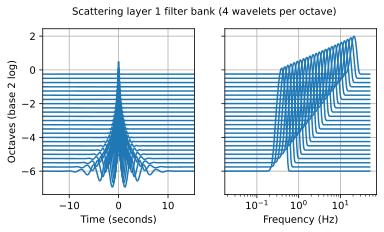

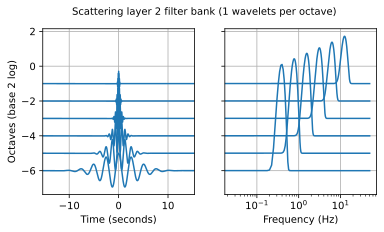

In [47]:
for layer_index, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 3))

    # Show each wavelet in time and frequency domains
    for wavelet, wavelet_spectrum, octave in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):
        ax[0].plot(bank.times, wavelet.real + octave, "C0")
        log_spectrum = np.log(np.abs(wavelet_spectrum) + 1)
        ax[1].plot(bank.frequencies, log_spectrum + octave, "C0")

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-3 * bank.widths.max(), 3 * bank.widths.max())
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()
    fig.suptitle(
        f"Scattering layer {layer_index + 1} filter bank "
        f"({bank.resolution} wavelets per octave)",
        size="medium",
    )